In [2]:
#You WILL need the following in bash:
#    pip install numpy pandas matplotlib seaborn scikit-learn

# MAKE SURE EVERYTHING IS UP TO DATE IF PREDOWNLOADED!!!


In [3]:
# General things for functions
import numpy as np # Numerical commands
import pandas as pd # Data manipulation

#Visualization tools for plotting
import matplotlib.pyplot as plt 
import seaborn as sns


#Machine learning parts itself
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [4]:
#Importing of the files. This will take a WHILE
testAway = pd.read_csv('testDataV3_away.txt')
testHome = pd.read_csv('testDataV3_home.txt')
testY = pd.read_csv('testDataV3_y.txt')

trainAway = pd.read_csv('trainDataV3_away.txt')
trainHome = pd.read_csv('trainDataV3_home.txt')
trainY = pd.read_csv('trainDataV3_y.txt')

In [5]:
def calculate_game_stats(df):
    # This will calculate the total number of games played
    df['TOTAL_GAMES_PLAYED'] = df['TEAM_GAME_WON_season_sum'] + df['TEAM_GAME_DRAW_season_sum'] + df['TEAM_GAME_LOST_season_sum']
    
    # Calculate Win perctengae: Wins / (total of all games)
    # This is of course to determine "good" compared to "bad" teams and see what factors are different
    df['WIN_PERCENTAGE'] = (df['TEAM_GAME_WON_season_sum'] / df['TOTAL_GAMES_PLAYED']) *100
    
    return df


trainHome = calculate_game_stats(trainHome)
trainAway = calculate_game_stats(trainAway)
testHome = calculate_game_stats(testHome)
testAway = calculate_game_stats(testAway)


print("Train Home Data with Stats:")
print(trainHome[['TEAM_GAME_WON_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_GAME_LOST_season_sum', 'TOTAL_GAMES_PLAYED', 'WIN_PERCENTAGE']].head())

print("\nTrain Away Data with Stats:")
print(trainAway[['TEAM_GAME_WON_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_GAME_LOST_season_sum', 'TOTAL_GAMES_PLAYED', 'WIN_PERCENTAGE']].head())


# Below was a simple test to ensure the test data win loss columns were created
# This is not to be used until model evaluation with the training data

# print("\nTest Home Data with Stats:")
# print(testHome[['TEAM_GAME_WON_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_GAME_LOST_season_sum', 'TOTAL_GAMES_PLAYED', 'WIN_LOSS_RATIO']].head())

# print("\nTest Away Data with Stats:")
# print(testAway[['TEAM_GAME_WON_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_GAME_LOST_season_sum', 'TOTAL_GAMES_PLAYED', 'WIN_LOSS_RATIO']].head())

Train Home Data with Stats:
   TEAM_GAME_WON_season_sum  TEAM_GAME_DRAW_season_sum  \
0                       1.0                        6.0   
1                       8.0                        4.0   
2                       2.0                        4.0   
3                       7.0                        0.0   
4                       1.0                        6.0   

   TEAM_GAME_LOST_season_sum  TOTAL_GAMES_PLAYED  WIN_PERCENTAGE  
0                       10.0                17.0        5.882353  
1                        1.0                13.0       61.538462  
2                        8.0                14.0       14.285714  
3                        5.0                12.0       58.333333  
4                       10.0                17.0        5.882353  

Train Away Data with Stats:
   TEAM_GAME_WON_season_sum  TEAM_GAME_DRAW_season_sum  \
0                       5.0                        8.0   
1                       1.0                        4.0   
2                 

Analysis for Home Teams:
Top differences between high and low win rate teams:
TEAM_GOALS_season_sum: 160.52% higher for high win rate teams
TEAM_SHOTS_ON_TARGET_season_sum: 94.18% higher for high win rate teams
TEAM_SUCCESSFUL_PASSES_season_sum: 67.22% higher for high win rate teams
TEAM_SHOTS_TOTAL_season_sum: 64.68% higher for high win rate teams
TEAM_PASSES_season_sum: 63.16% higher for high win rate teams
TEAM_DANGEROUS_ATTACKS_season_sum: 54.84% higher for high win rate teams
TEAM_CORNERS_season_sum: 48.91% higher for high win rate teams
TEAM_ATTACKS_season_sum: 43.71% higher for high win rate teams
TEAM_SAVES_season_sum: -25.55% lower for high win rate teams
TEAM_REDCARDS_season_sum: -19.25% lower for high win rate teams


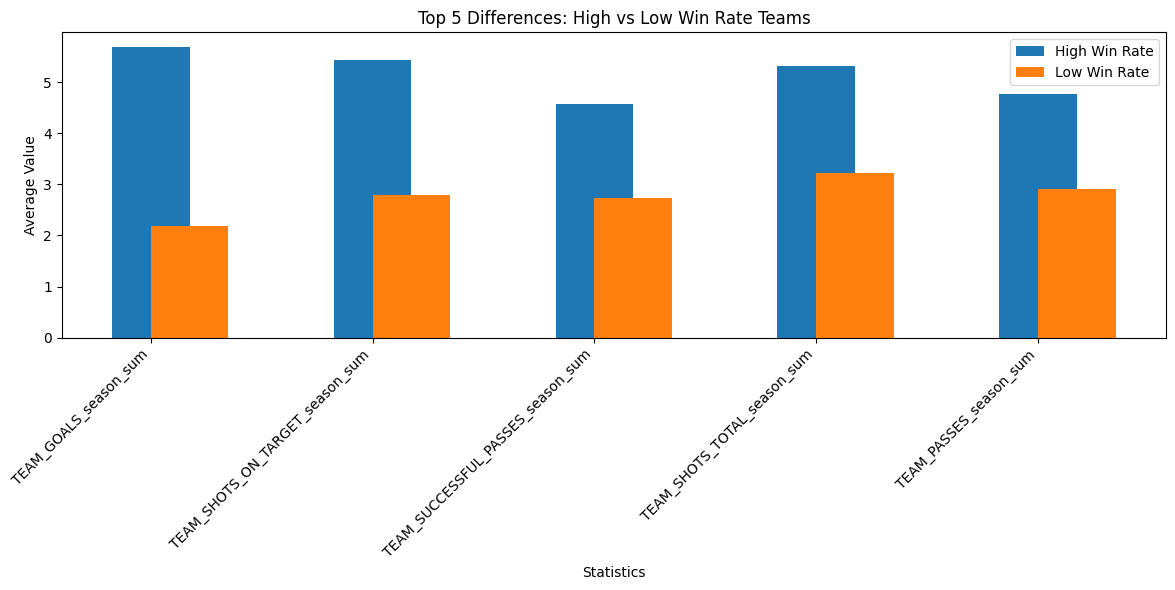


Analysis for Away Teams:
Top differences between high and low win rate teams:
TEAM_GOALS_season_sum: 156.10% higher for high win rate teams
TEAM_SHOTS_ON_TARGET_season_sum: 92.04% higher for high win rate teams
TEAM_SUCCESSFUL_PASSES_season_sum: 68.48% higher for high win rate teams
TEAM_PASSES_season_sum: 63.92% higher for high win rate teams
TEAM_SHOTS_TOTAL_season_sum: 62.95% higher for high win rate teams
TEAM_DANGEROUS_ATTACKS_season_sum: 51.63% higher for high win rate teams
TEAM_CORNERS_season_sum: 48.62% higher for high win rate teams
TEAM_ATTACKS_season_sum: 42.15% higher for high win rate teams
TEAM_SAVES_season_sum: -25.14% lower for high win rate teams
TEAM_REDCARDS_season_sum: -21.87% lower for high win rate teams


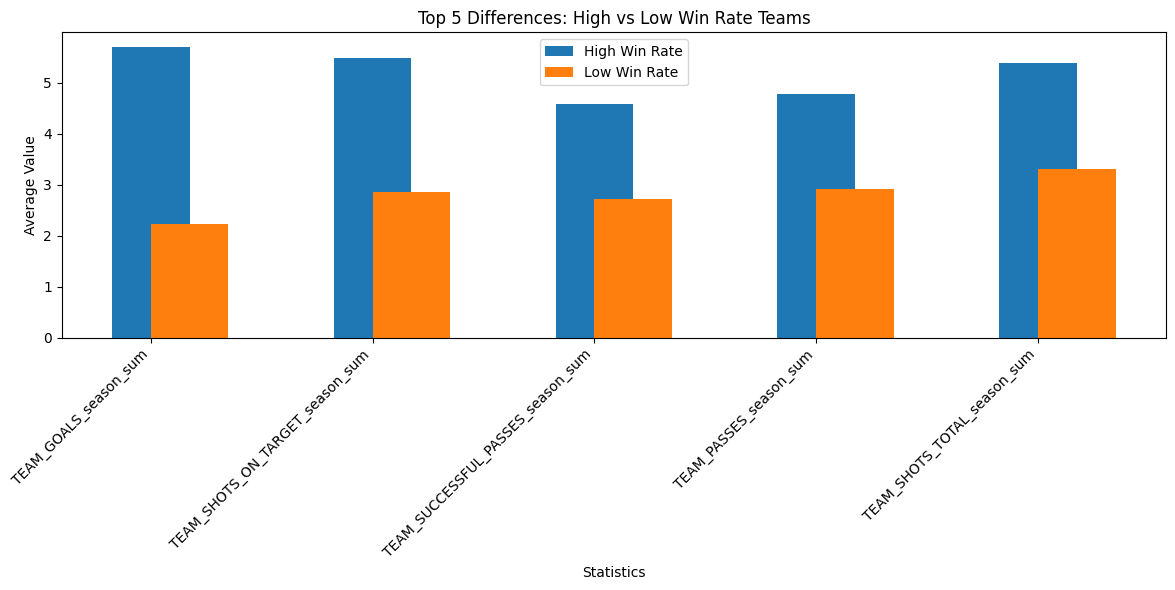

In [ ]:
def analyze_high_vs_low_winrate(df):
    # Median win #
    median_win_percentage = df['WIN_PERCENTAGE'].median()
    
    # High and low win rate groups (for comparison)
    high_winrate = df[df['WIN_PERCENTAGE'] >= median_win_percentage]
    low_winrate = df[df['WIN_PERCENTAGE'] < median_win_percentage]
    
    # List of statistics to compare
    stats_to_compare = [
        'TEAM_SHOTS_TOTAL_season_sum', 'TEAM_SHOTS_ON_TARGET_season_sum',
        'TEAM_PASSES_season_sum', 'TEAM_SUCCESSFUL_PASSES_season_sum',
        'TEAM_SAVES_season_sum', 'TEAM_CORNERS_season_sum',
        'TEAM_FOULS_season_sum', 'TEAM_YELLOWCARDS_season_sum',
        'TEAM_REDCARDS_season_sum', 'TEAM_ATTACKS_season_sum',
        'TEAM_DANGEROUS_ATTACKS_season_sum', 'TEAM_GOALS_season_sum'
    ]
    
    # Average stats per high/low team
    high_winrate_stats = high_winrate[stats_to_compare].mean()
    low_winrate_stats = low_winrate[stats_to_compare].mean()
    
    # Find the difference to see what matters
    percentage_diff = ((high_winrate_stats - low_winrate_stats) / low_winrate_stats) * 100
    
    sorted_diff = percentage_diff.abs().sort_values(ascending=False)

    print("Top differences between high and low win rate teams:")
    for stat in sorted_diff.index[:10]:  # Top 10 differences
        diff = percentage_diff[stat]
        print(f"{stat}: {diff:.2f}% {'higher' if diff > 0 else 'lower'} for high win rate teams")
    
    # Shows the top 5 and their average values for comparison
    top_5_stats = sorted_diff.index[:5]
    plt.figure(figsize=(12, 6))
    x = range(len(top_5_stats))
    plt.bar(x, high_winrate_stats[top_5_stats], width=0.35, align='center', label='High Win Rate')
    plt.bar(x, low_winrate_stats[top_5_stats], width=0.35, align='edge', label='Low Win Rate')
    plt.xlabel('Statistics')
    plt.ylabel('Average Value')
    plt.title('Top 5 Differences: High vs Low Win Rate Teams')
    plt.xticks(x, top_5_stats, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the analysis for both home and away data
print("Analysis for Home Teams:")
analyze_high_vs_low_winrate(trainHome)

print("\nAnalysis for Away Teams:")
analyze_high_vs_low_winrate(trainAway)
